In [1]:

import os
import io
import zipfile
import random
import math
from pathlib import Path
from typing import Tuple, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    roc_curve, classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# xgboost (install if needed)
try:
    import xgboost as xgb
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
    import xgboost as xgb

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Make cuDNN deterministic (note: may reduce performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cuda


In [ ]:

def find_zip(name: str) -> Path:
    candidates = [Path(".")/name, Path("..")/name]
    for c in candidates:
        if c.exists():
            return c.resolve()
    raise FileNotFoundError(f"Could not find {name} in . or ..")

def unzip_to_dir(zip_path: Path, out_dir: Path):
    if out_dir.exists() and any(out_dir.iterdir()):
        # Already unzipped
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)


def prepare_data_dirs(train_zip="train.zip", out_root=Path("./data")) -> Tuple[Path, Path]:
    out_root.mkdir(parents=True, exist_ok=True)
    train_dir = out_root / "train"
    tz = find_zip(train_zip)
    unzip_to_dir(tz, train_dir)

    return train_dir, train_dir

train_dir, test_dir = prepare_data_dirs()
print(f"Train dir: {train_dir}")
print(f"Test  dir: {test_dir}  (same as train; using 80/20 split for test)")

# Define transforms (unchanged)
IMG_SIZE = 224
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

# Load full dataset from *train* only (unchanged line except conceptually now used for test too)
full_train = datasets.ImageFolder(root=str(train_dir), transform=train_tf)


class_names = full_train.classes
num_classes = len(class_names)
print("Classes:", class_names, " | #classes:", num_classes)
print("Train images (total):", len(full_train))

# Build a stratified 80/20 split from the training folder (unchanged)
def stratified_indices(dataset: datasets.ImageFolder, val_size=0.2, seed=42):
    targets = [y for _, y in dataset.samples]
    idxs = np.arange(len(dataset))
    tr_idx, val_idx = train_test_split(
        idxs, test_size=val_size, random_state=seed, stratify=targets
    )
    return tr_idx, val_idx

train_idx, val_idx = stratified_indices(full_train, val_size=0.2, seed=42)

# Re-wrap datasets
train_ds = Subset(full_train, train_idx)
val_base = datasets.ImageFolder(root=str(train_dir), transform=eval_tf)
val_ds = Subset(val_base, val_idx)

test_ds = val_ds  # the 20% from train becomes the test set

# DataLoaders (unchanged)
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")


Train dir: data\train
Test  dir: data\train  (same as train; using 80/20 split for test)
Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']  | #classes: 12
Train images (total): 4750
Train/Val/Test sizes: 3800/950/950


In [ ]:

def compute_class_weights(dataset: Subset, num_classes: int) -> torch.Tensor:
    counts = np.zeros(num_classes, dtype=np.int64)
    base: datasets.ImageFolder = dataset.dataset
    for i in dataset.indices:
        _, y = base.samples[i]
        counts[y] += 1
    weights = counts.sum() / (counts + 1e-8)  # inverse frequency
    weights = weights / weights.mean()        # normalize
    return torch.tensor(weights, dtype=torch.float32)

class_weights = compute_class_weights(train_ds, num_classes=num_classes).to(DEVICE)
print("Class weights:", class_weights.cpu().numpy())


Class weights: [1.3042071  0.87783164 1.1959977  0.56008893 1.5473642  0.720746
 0.52367777 1.5473642  0.66315615 1.4804512  0.6898828  0.8892321 ]


In [4]:
# %%
ACTIVATIONS = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "gelu": nn.GELU,
    "silu": nn.SiLU,   # a.k.a. swish
}

class SmallCNN(nn.Module):
    def __init__(self,
                 in_ch: int = 3,
                 num_classes: int = 12,
                 act_name: str = "relu",
                 dropout: float = 0.3,
                 conv_channels: List[int] = [32, 64, 128, 256],
                 kernel_size: int = 3,
                 pool_every: int = 2,
                 feature_dim: int = 256):
        super().__init__()
        Act = ACTIVATIONS.get(act_name.lower(), nn.ReLU)

        layers = []
        ch = in_ch
        for i, ch_out in enumerate(conv_channels):
            layers += [
                nn.Conv2d(ch, ch_out, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
                nn.BatchNorm2d(ch_out),
                Act(inplace=True) if Act in (nn.ReLU, nn.LeakyReLU, nn.SiLU) else Act(),
            ]
            if (i + 1) % pool_every == 0:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            ch = ch_out

        self.features = nn.Sequential(*layers)

        # compute spatial size after convs/pools, using a dummy tensor
        with torch.no_grad():
            dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
            feat_out = self.features(dummy)
            self._feat_shape = feat_out.shape[1:]  # (C, H, W)
            flat_size = feat_out.numel()

        self.gap = nn.AdaptiveAvgPool2d((1,1))  # Global Average Pooling

        # Project to a compact feature vector
        self.feat_head = nn.Sequential(
            nn.Flatten(),                 # flatten pooled Cx1x1 -> C
            nn.Linear(self._feat_shape[0], feature_dim),
            nn.BatchNorm1d(feature_dim),
            nn.Dropout(p=dropout),
            Act()
        )

        self.classifier = nn.Linear(feature_dim, num_classes)
        self.feature_dim = feature_dim

    def forward_features(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.feat_head(x)
        return x  # (B, feature_dim)

    def forward(self, x):
        feats = self.forward_features(x)
        logits = self.classifier(feats)
        return logits, feats

def make_model(num_classes: int,
               act_name: str = "relu",
               feature_dim: int = 256) -> SmallCNN:
    model = SmallCNN(num_classes=num_classes, act_name=act_name, feature_dim=feature_dim)
    return model.to(DEVICE)


In [5]:
# %%
def train_one_epoch(model: nn.Module, loader: DataLoader,
                    optimizer: torch.optim.Optimizer,
                    criterion, epoch: int, log_every: int = 100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for step, (x, y) in enumerate(loader):
        x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        if (step + 1) % log_every == 0:
            print(f"  step {step+1}/{len(loader)} | loss={loss.item():.4f}")

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, return_probs: bool = True):
    model.eval()
    all_logits = []
    all_targets = []
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        logits, _ = model(x)
        all_logits.append(logits.cpu())
        all_targets.append(y)

    logits = torch.cat(all_logits, dim=0)
    y_true = torch.cat(all_targets, dim=0).numpy()

    y_pred = logits.argmax(1).numpy()
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )

    probs = F.softmax(logits, dim=1).numpy() if return_probs else None
    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "probs": probs,
        "acc": acc,
        "precision_micro": precision,
        "recall_micro": recall,
        "f1_micro": f1
    }

def compute_micro_roc_auc(y_true: np.ndarray, probs: np.ndarray, n_classes: int) -> float:
    y_bin = label_binarize(y_true, classes=np.arange(n_classes))
    # Some classifiers may not output prob for all classes; ensure shape matches
    if probs.shape[1] != n_classes:
        raise ValueError("Probabilities do not match number of classes.")
    return roc_auc_score(y_bin, probs, average="micro", multi_class="ovr")

def plot_micro_roc(y_true: np.ndarray, probs: np.ndarray, n_classes: int, title: str):
    y_bin = label_binarize(y_true, classes=np.arange(n_classes))
    fpr, tpr, _ = roc_curve(y_bin.ravel(), probs.ravel())
    auc_micro = roc_auc_score(y_bin, probs, average="micro", multi_class="ovr")

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"micro-avg ROC (AUC={auc_micro:.3f})")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [21]:
# %%
ACT_FUNC = "silu"       # try: "relu", "leaky_relu", "gelu", "silu"
FEATURE_DIM = 256
LR = 3e-4
EPOCHS = 15
PATIENCE = 3
WEIGHT_DECAY = 1e-4

model = make_model(num_classes=num_classes, act_name=ACT_FUNC, feature_dim=FEATURE_DIM)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(weight=class_weights)

best_val_f1 = -np.inf
best_state = None
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    val_metrics = evaluate(model, val_loader)
    print(f"  Train loss={tr_loss:.4f} | Train acc={tr_acc:.4f}")
    print(f"  Val   acc={val_metrics['acc']:.4f} | F1_micro={val_metrics['f1_micro']:.4f}")

    if val_metrics['f1_micro'] > best_val_f1:
        best_val_f1 = val_metrics['f1_micro']
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# load best model
if best_state is not None:
    model.load_state_dict(best_state)



Epoch 1/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=1.6414
  Train loss=1.8915 | Train acc=0.3682
  Val   acc=0.5989 | F1_micro=0.5989

Epoch 2/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=1.9355
  Train loss=1.5054 | Train acc=0.4976
  Val   acc=0.5968 | F1_micro=0.5968

Epoch 3/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=2.0026
  Train loss=1.3777 | Train acc=0.5432
  Val   acc=0.6463 | F1_micro=0.6463

Epoch 4/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=1.1694
  Train loss=1.2597 | Train acc=0.5903
  Val   acc=0.6105 | F1_micro=0.6105

Epoch 5/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=1.4697
  Train loss=1.1614 | Train acc=0.6142
  Val   acc=0.6589 | F1_micro=0.6589

Epoch 6/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=1.1368
  Train loss=1.1076 | Train acc=0.6329
  Val   acc=0.6811 | F1_micro=0.6811

Epoch 7/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=1.0041
  Train loss=1.0481 | Train acc=0.6561
  Val   acc=0.6705 | F1_micro=0.6705

Epoch 8/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=0.8226
  Train loss=0.9851 | Train acc=0.6742
  Val   acc=0.6295 | F1_micro=0.6295

Epoch 9/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=1.0325
  Train loss=0.9308 | Train acc=0.6932
  Val   acc=0.7632 | F1_micro=0.7632

Epoch 10/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=0.9413
  Train loss=0.8760 | Train acc=0.7063
  Val   acc=0.6400 | F1_micro=0.6400

Epoch 11/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=0.7749
  Train loss=0.8774 | Train acc=0.7124
  Val   acc=0.7358 | F1_micro=0.7358

Epoch 12/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=0.7230
  Train loss=0.8284 | Train acc=0.7208
  Val   acc=0.7653 | F1_micro=0.7653

Epoch 13/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=0.6705
  Train loss=0.8054 | Train acc=0.7279
  Val   acc=0.7621 | F1_micro=0.7621

Epoch 14/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=0.6790
  Train loss=0.7746 | Train acc=0.7405
  Val   acc=0.7495 | F1_micro=0.7495

Epoch 15/15


C:\Users\muzir\AppData\Local\Temp\ipykernel_37204\1711716459.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)


  step 100/119 | loss=0.7670
  Train loss=0.7486 | Train acc=0.7500
  Val   acc=0.7916 | F1_micro=0.7916



=== Baseline CNN (Softmax) ===
Accuracy: 0.7916 | Precision (micro): 0.7916 | Recall (micro): 0.7916 | F1 (micro): 0.7916 | ROC-AUC (micro): 0.9846


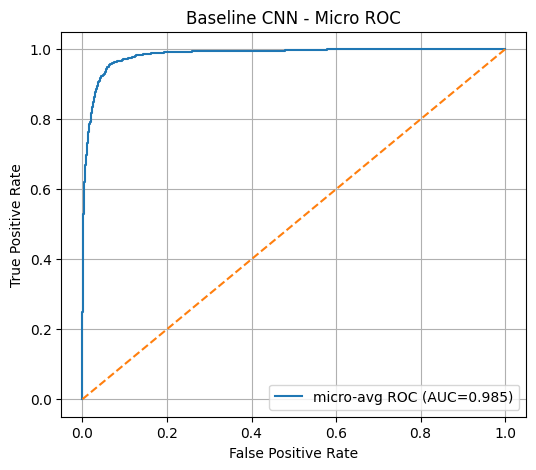

In [22]:
# %%
cnn_test = evaluate(model, test_loader)
try:
    cnn_auc = compute_micro_roc_auc(cnn_test["y_true"], cnn_test["probs"], num_classes)
except Exception as e:
    print("Warning (CNN ROC-AUC):", e)
    cnn_auc = float("nan")

print("\n=== Baseline CNN (Softmax) ===")
print(f"Accuracy: {cnn_test['acc']:.4f} | Precision (micro): {cnn_test['precision_micro']:.4f} "
      f"| Recall (micro): {cnn_test['recall_micro']:.4f} | F1 (micro): {cnn_test['f1_micro']:.4f} | ROC-AUC (micro): {cnn_auc:.4f}")

plot_micro_roc(cnn_test["y_true"], cnn_test["probs"], num_classes, title="Baseline CNN - Micro ROC")


# %% [markdown]
# ## 7. Feature Extraction (Penultimate Layer)


In [23]:
# %%
@torch.no_grad()
def extract_features(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    feats_list = []
    y_list = []
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        _, feats = model(x)
        feats_list.append(feats.cpu().numpy())
        y_list.append(y.numpy())
    X = np.concatenate(feats_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = extract_features(model, train_loader)
X_val,   y_val   = extract_features(model, val_loader)
X_test,  y_test  = extract_features(model, test_loader)

print("Feature shapes:", X_train.shape, X_val.shape, X_test.shape)


Feature shapes: (3800, 256) (950, 256) (950, 256)


SVM (val) acc: 0.8958

=== CNN → SVM ===
Accuracy: 0.8958 | Precision (micro): 0.8958 | Recall (micro): 0.8958 | F1 (micro): 0.8958 | ROC-AUC (micro): 0.9916


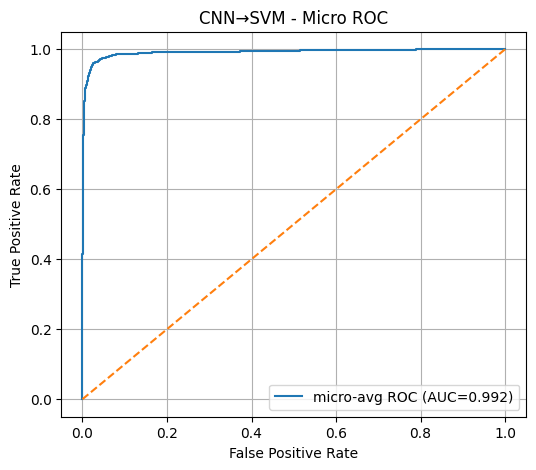

In [ ]:
# %%
def train_calibrated_svm(X_tr, y_tr, X_val, y_val) -> CalibratedClassifierCV:
    scaler = StandardScaler()
    X_trs = scaler.fit_transform(X_tr)
    X_vals = scaler.transform(X_val)

    base_svm = LinearSVC(C=1.0, class_weight="balanced", max_iter=5000)
    clf = CalibratedClassifierCV(base_svm, cv=3, method="sigmoid")
    clf.fit(X_trs, y_tr)
   
    val_pred = clf.predict(X_vals)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"SVM (val) acc: {val_acc:.4f}")
    
    class SVMWrapper:
        def __init__(self, scaler, clf):
            self.scaler = scaler
            self.clf = clf
        def predict(self, X):
            return self.clf.predict(self.scaler.transform(X))
        def predict_proba(self, X):
            return self.clf.predict_proba(self.scaler.transform(X))
    return SVMWrapper(scaler, clf)

svm_model = train_calibrated_svm(X_train, y_train, X_val, y_val)

svm_pred = svm_model.predict(X_test)
svm_proba = svm_model.predict_proba(X_test)

svm_acc = accuracy_score(y_test, svm_pred)
svm_prec, svm_rec, svm_f1, _ = precision_recall_fscore_support(
    y_test, svm_pred, average="micro", zero_division=0
)
svm_auc = roc_auc_score(label_binarize(y_test, classes=np.arange(num_classes)),
                        svm_proba, average="micro", multi_class="ovr")

print("\n=== CNN → SVM ===")
print(f"Accuracy: {svm_acc:.4f} | Precision (micro): {svm_prec:.4f} "
      f"| Recall (micro): {svm_rec:.4f} | F1 (micro): {svm_f1:.4f} | ROC-AUC (micro): {svm_auc:.4f}")

plot_micro_roc(y_test, svm_proba, num_classes, title="CNN→SVM - Micro ROC")



=== CNN → XGBoost ===
Accuracy: 0.8589 | Precision (micro): 0.8589 | Recall (micro): 0.8589 | F1 (micro): 0.8589 | ROC-AUC (micro): 0.9934


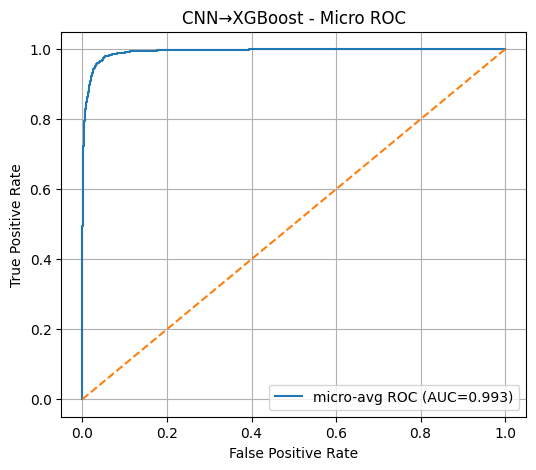

In [ ]:
# %%
def train_xgb(X_tr, y_tr, X_val, y_val, num_classes: int) -> xgb.XGBClassifier:
    model = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=num_classes,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",   # f
        n_jobs=0,
        eval_metric="mlogloss",
        verbosity=0,
    )
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    return model

xgb_model = train_xgb(X_train, y_train, X_val, y_val, num_classes=num_classes)

xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_prec, xgb_rec, xgb_f1, _ = precision_recall_fscore_support(
    y_test, xgb_pred, average="micro", zero_division=0
)
xgb_auc = roc_auc_score(label_binarize(y_test, classes=np.arange(num_classes)),
                        xgb_proba, average="micro", multi_class="ovr")

print("\n=== CNN → XGBoost ===")
print(f"Accuracy: {xgb_acc:.4f} | Precision (micro): {xgb_prec:.4f} "
      f"| Recall (micro): {xgb_rec:.4f} | F1 (micro): {xgb_f1:.4f} | ROC-AUC (micro): {xgb_auc:.4f}")

plot_micro_roc(y_test, xgb_proba, num_classes, title="CNN→XGBoost - Micro ROC")


In [26]:
# %%
results = pd.DataFrame([
    {
        "Model": "Baseline CNN (Softmax)",
        "Accuracy": cnn_test["acc"],
        "Precision_micro": cnn_test["precision_micro"],
        "Recall_micro": cnn_test["recall_micro"],
        "F1_micro": cnn_test["f1_micro"],
        "ROC_AUC_micro": cnn_auc
    },
    {
        "Model": "CNN → SVM (Calibrated)",
        "Accuracy": svm_acc,
        "Precision_micro": svm_prec,
        "Recall_micro": svm_rec,
        "F1_micro": svm_f1,
        "ROC_AUC_micro": svm_auc
    },
    {
        "Model": "CNN → XGBoost",
        "Accuracy": xgb_acc,
        "Precision_micro": xgb_prec,
        "Recall_micro": xgb_rec,
        "F1_micro": xgb_f1,
        "ROC_AUC_micro": xgb_auc
    }
]).set_index("Model")

results.style.format("{:.4f}")


,Accuracy,Precision_micro,Recall_micro,F1_micro,ROC_AUC_micro
Model,,,,,
Baseline CNN (Softmax),0.7916,0.7916,0.7916,0.7916,0.9846
CNN → SVM (Calibrated),0.8958,0.8958,0.8958,0.8958,0.9916
CNN → XGBoost,0.8589,0.8589,0.8589,0.8589,0.9934


Best (by F1_micro): SVM

Classification Report (best):

                           precision    recall  f1-score   support

              Black-grass       0.77      0.70      0.73        53
                 Charlock       0.94      0.95      0.94        78
                 Cleavers       0.93      0.90      0.91        58
         Common Chickweed       0.91      0.98      0.94       122
             Common wheat       0.91      0.91      0.91        44
                  Fat Hen       0.90      0.85      0.88        95
         Loose Silky-bent       0.86      0.87      0.86       131
                    Maize       0.98      0.91      0.94        44
        Scentless Mayweed       0.82      0.92      0.87       103
          Shepherds Purse       0.91      0.63      0.74        46
Small-flowered Cranesbill       0.93      0.98      0.96        99
               Sugar beet       0.96      0.95      0.95        77

                 accuracy                           0.90       950
    

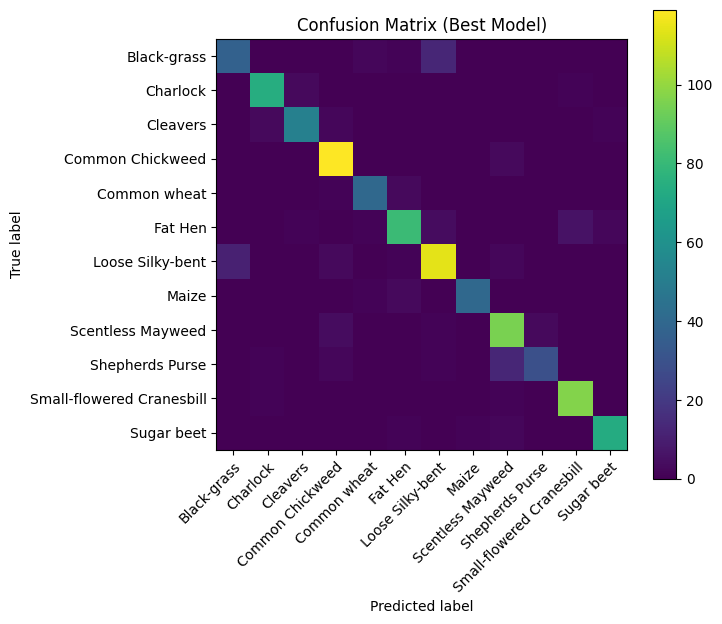

In [27]:
# %%
def best_by_f1():
    triples = [
        ("CNN", cnn_test["y_true"], cnn_test["y_pred"]),
        ("SVM", y_test, svm_pred),
        ("XGB", y_test, xgb_pred),
    ]
    scores = []
    for name, yt, yp in triples:
        _, _, f1, _ = precision_recall_fscore_support(yt, yp, average="micro", zero_division=0)
        scores.append((name, f1))
    scores.sort(key=lambda z: z[1], reverse=True)
    return scores[0][0]

best = best_by_f1()
print("Best (by F1_micro):", best)

if best == "CNN":
    y_true_b, y_pred_b = cnn_test["y_true"], cnn_test["y_pred"]
elif best == "SVM":
    y_true_b, y_pred_b = y_test, svm_pred
else:
    y_true_b, y_pred_b = y_test, xgb_pred

print("\nClassification Report (best):\n")
print(classification_report(y_true_b, y_pred_b, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true_b, y_pred_b)
fig, ax = plt.subplots(figsize=(7.5, 6.5))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion Matrix (Best Model)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.show()
